## Rank sum test

In [44]:
''' Dependencies '''
from sklearn.decomposition import PCA
from tqdm.auto import tqdm
import warnings
import pandas as pd
import numpy as np
import scipy
import sys
import statsmodels.api as sm
from tqdm import tqdm as pbar

# my scripts
from pyaldata import * 
import preprocess
from utils import *

# Plotting
from IPython.display import display, set_matplotlib_formats, HTML
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.colors
import matplotlib.pyplot as plt
import seaborn as sns

cs = ['#43D789', '#801607', '#8DB8ED', '#94B0B6', '#e42c12', '#005CA8', '#127340', '#111851'] # Line colors
cmap = matplotlib.colors.ListedColormap(['#ff9c8d', '#dafce3']) # Color for False and True

sns.set(rc={'figure.figsize':(10, 5)})
sns.set_style('ticks', rc={ 'figure.facecolor': 'none', 'axes.facecolor':'none'})
sns.set_context('notebook', rc={'lines.linewidth':1.5})

%config InlineBackend.figure_format = 'retina'

In [45]:
''' Load dictionaries '''

main_dict = np.load('/Users/Daphne/Data/main_dict_dims.npy', allow_pickle='TRUE').item()
surr_dict = np.load('/Users/Daphne/Data/surr_dict_20.npy', allow_pickle='TRUE').item()
THRESHOLDS_VARE = np.round(np.arange(0.2, 0.95, 0.025), 3)

evar_to_pcs = []
for s in main_dict.keys():
    evar_to_pcs.append([np.argmax(main_dict[s]['model'].explained_variance_ratio_.cumsum() > THRESHOLDS_VARE[i]) for i in range(len(THRESHOLDS_VARE))])

    ''' Experimental sessions and electrode maps '''
m1_emap  = localize_elecs(read_cmp(file_path='/Users/Daphne/Data/Chewie Left M1 SN 6250-001474.cmp'),  elecs=range(1,97))
pmd_emap = localize_elecs(read_cmp(file_path='/Users/Daphne/Data/Chewie Left PMd SN 6251-001469.cmp'), elecs=range(1,97))

In [48]:
''' Parameters '''

MONKEY_C = 8
MONKEY_M = 7
OTHER_ARRAY_D = 50
total_n_sessions = [main_dict[s]['pcs'].shape[0] for s in main_dict.keys()]
# dims_normalized = [evar_to_pcs[i, :] / total_n_sessions[i] for i in range(len(total_n_sessions))]
DIM_RANGE = [5, 10, 15, 20] # by manifold dim
varexp = ['0.3', '0.4', '0.45', '0.525'] # For surrogates

### Non parametric rank sum test

In [75]:
# D = '5'
# s = '2016-09-09'
# vare = '0.475'

# # Choose dim by dims
# df_dist_surr = surr_dict['1']['vare'][vare]['distances_df']
# df_dist_actual = main_dict[s]['dim'][D]['distances_df']

# df_both = pd.concat([df_dist_surr, df_dist_actual])

### Look at one session across 3 dimensions (5, 10, 15)

In [81]:
df_both_Ds = []

for i in range(len(DIM_RANGE)):
    
    D = str(DIM_RANGE[i])
    V = varexp[i]
    
    # Choose dim by dims
    df_dist_surr = surr_dict['1']['vare'][V]['distances_df']
    df_dist_actual = main_dict['2016-09-09']['dim'][D]['distances_df']
    
    df_both = pd.concat([df_dist_surr, df_dist_actual])
    
    df_both_Ds.append(df_both)

In [82]:
''' Figure settings '''
sns.set(rc={'figure.figsize':(10, 5)})
sns.set_style('ticks', rc={ 'figure.facecolor': 'none', 'axes.facecolor':'none'})
sns.set_context('notebook', rc={'lines.linewidth':1.5})

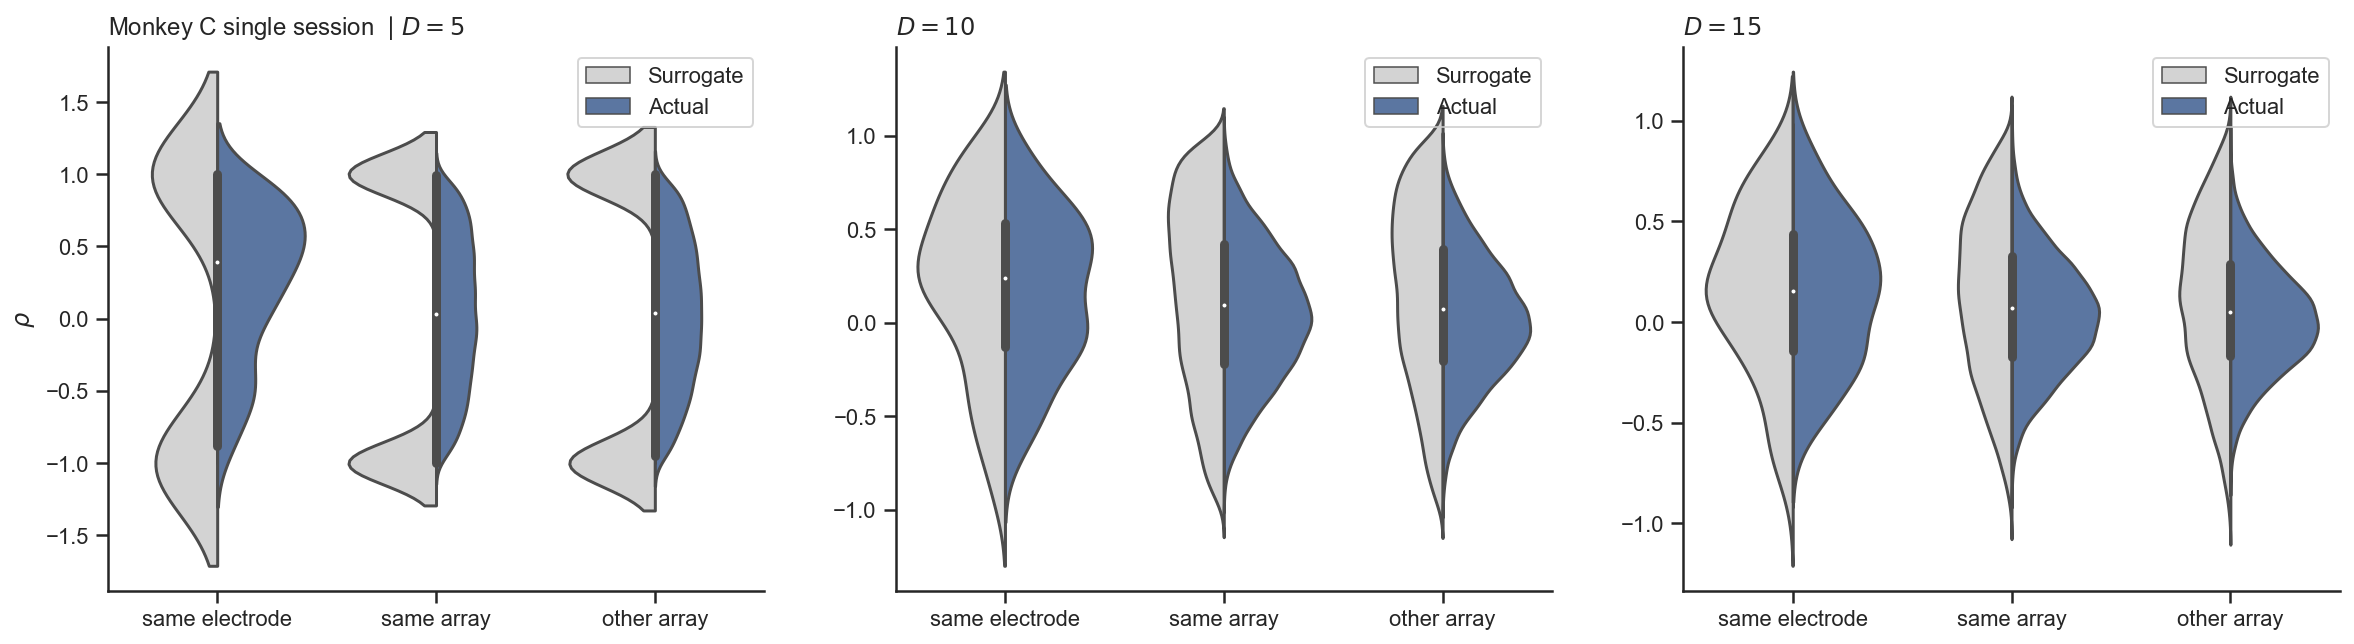

In [128]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['lightgray', 'b'])

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

axs[0].set_title(r'Monkey C single session $\mid D = 5$' , loc='left')
sns.violinplot(y='correlation', x='category', order=['same electrode', 'same array', 'other array'], data=df_both_Ds[0], hue='Type', split=True, saturation=0.7, ax=axs[0]);
axs[0].set_ylabel(r'$\rho$')
axs[0].set_xlabel('')
axs[0].set_xticks([0, 1, 2], ['same electrode', 'same region', 'other region'])

axs[1].set_title(r'$D = 10$' , loc='left')
sns.violinplot(y='correlation', x='category', order=['same electrode', 'same array', 'other array'], data=df_both_Ds[1], hue='Type', split=True, saturation=0.7, ax=axs[1]);
axs[1].set_ylabel('')
axs[1].set_xlabel('')
axs[1].set_xticks([0, 1, 2], ['same electrode', 'same region', 'other region'])

axs[2].set_title(r'$D = 15$' , loc='left')
sns.violinplot(y='correlation', x='category', order=['same electrode', 'same array', 'other array'], data=df_both_Ds[2], hue='Type', split=True, saturation=0.7, ax=axs[2]);
axs[2].set_ylabel('')
axs[2].set_xlabel('')
axs[2].set_xticks([0, 1, 2], ['same electrode', 'same region', 'other region'])

axs[0].legend(loc='upper right')
axs[1].legend(loc='upper right')
axs[2].legend(loc='upper right')

sns.despine()

### Pool data across sessions

In [76]:
''' MONKEY C '''

D_all_df_both = []

for i in range(len(DIM_RANGE)):

    D = str(DIM_RANGE[i])
    V = varexp[i]
    
    # Actual
    df_across_actual = main_dict['2016-09-09']['dim'][D]['distances_df'] # initialize

    for i, s in enumerate(list(main_dict.keys())[:MONKEY_C]): # for all monkey C sessions
        if i == 0: pass
        df_across_actual.append(main_dict[s]['dim'][D]['distances_df'])

    # Surrogates
    df_across_surr = surr_dict['0']['vare'][V]['distances_df']

    for i, s in enumerate(list(surr_dict.keys())[:MONKEY_C]):
        if i == 0: pass
        df_across_surr.append(surr_dict[s]['vare'][V]['distances_df'])
        
    # concatenate
    df_both_across = pd.concat([df_across_surr, df_across_actual])
    D_all_df_both.append(df_both_across)

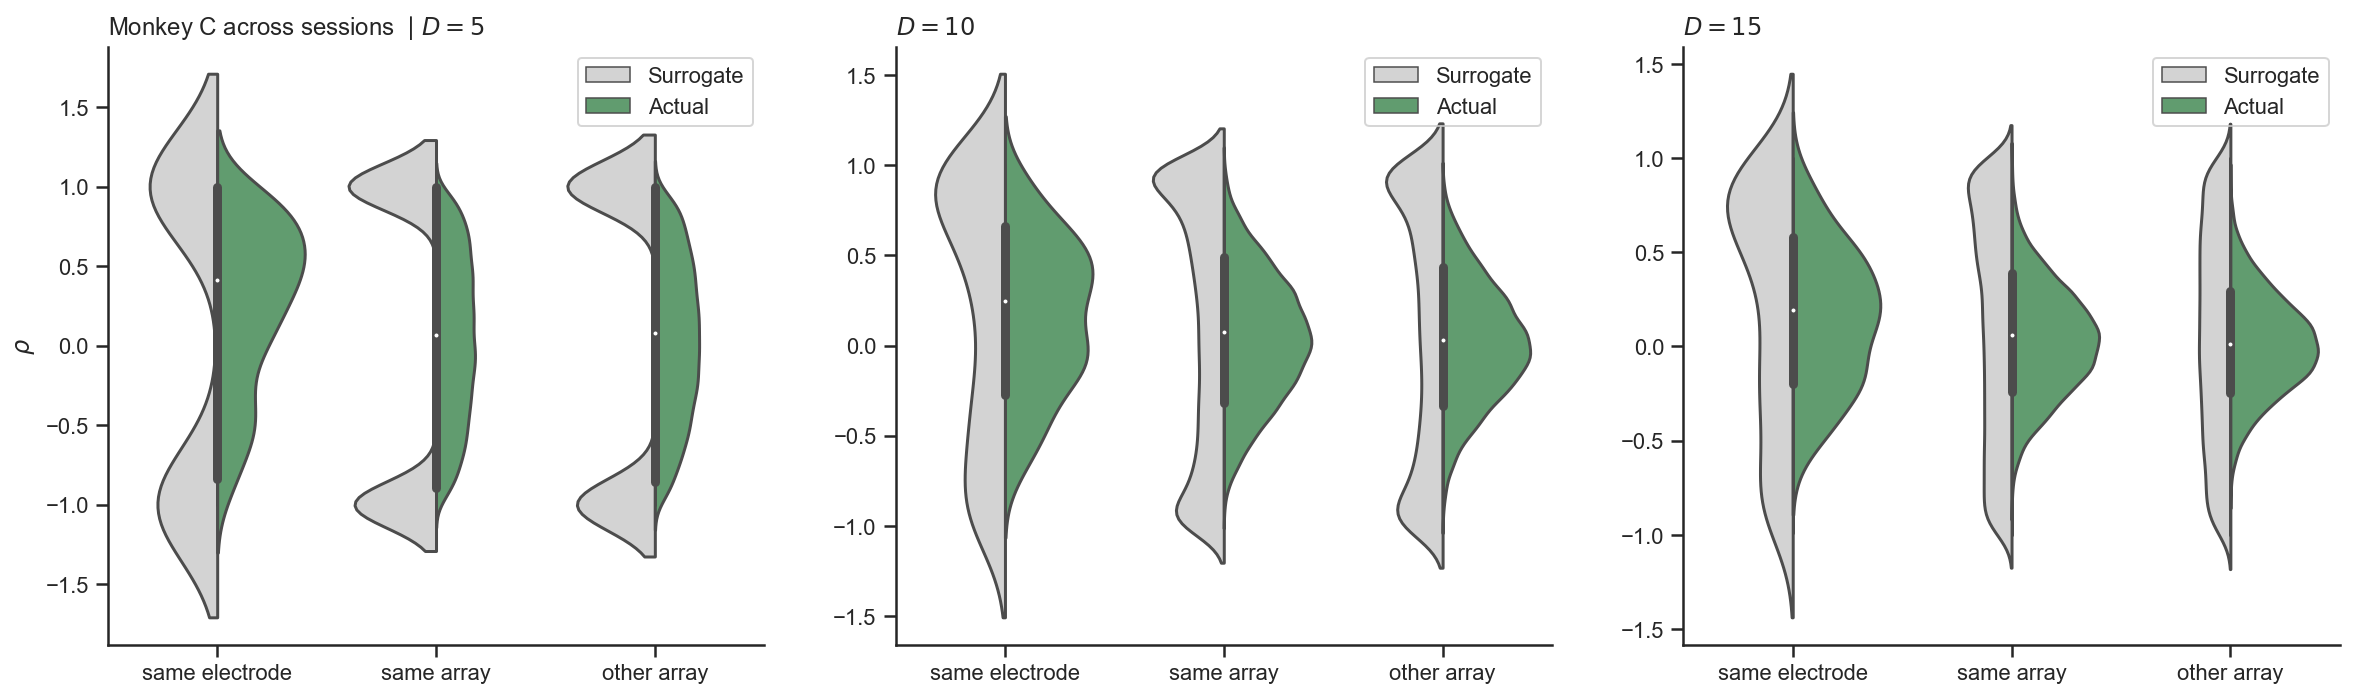

In [126]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['lightgray', 'g'])

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5.5))

axs[0].set_title(r'Monkey C across sessions $\mid D = 5$' , loc='left')
sns.violinplot(y='correlation', x='category', order=['same electrode', 'same array', 'other array'], data=D_all_df_both[0], hue='Type', split=True, saturation=0.7, ax=axs[0]);
axs[0].set_ylabel(r'$\rho$')
axs[0].set_xlabel('')
axs[0].set_xticks([0, 1, 2], ['same electrode', 'same region', 'other region'])

axs[1].set_title(r'$D = 10$' , loc='left')
sns.violinplot(y='correlation', x='category', order=['same electrode', 'same array', 'other array'], data=D_all_df_both[1], hue='Type', split=True, saturation=0.7, ax=axs[1]);
axs[1].set_ylabel('')
axs[1].set_xlabel('')
axs[1].set_xticks([0, 1, 2], ['same electrode', 'same region', 'other region'])

axs[2].set_title(r'$D = 15$' , loc='left')
sns.violinplot(y='correlation', x='category', order=['same electrode', 'same array', 'other array'], data=D_all_df_both[2], hue='Type', split=True, saturation=0.7, ax=axs[2]);
axs[2].set_ylabel('')
axs[2].set_xlabel('')
axs[2].set_xticks([0, 1, 2], ['same electrode', 'same region', 'other region'])

axs[0].legend(loc='upper right')
axs[1].legend(loc='upper right')
axs[2].legend(loc='upper right')
sns.despine()

In [80]:
# sns.kdeplot(rhos_SE_all, alpha=0.2, label='same electrode', shade=True)
# sns.kdeplot(rhos_SA_all, alpha=0.2, label='same region', shade=True)
# sns.kdeplot(rhos_OA_all, alpha=0.2, label='other region', shade=True)

# plt.title('Correlation distributions normalized by # obervations within groups | Monkey C' )
# plt.legend(fontsize=13, loc=2)
# plt.xlabel(r'$\rho$')
# sns.despine()

In [108]:
df_D5 = df_both_Ds[0] # select df

SE_D5 = df_D5.loc[(df_D5['Type'] == 'Actual') & (df_D5['category'] == 'same electrode')]['correlation'].values
SA_D5 = df_D5.loc[(df_D5['Type'] == 'Actual') & (df_D5['category'] == 'same array')]['correlation'].values
OA_D5 = df_D5.loc[(df_D5['Type'] == 'Actual') & (df_D5['category'] == 'other array')]['correlation'].values

In [109]:
scipy.stats.ranksums(SE_D5, SA_D5, alternative='two-sided')

RanksumsResult(statistic=5.655325078546309, pvalue=1.5555157803551437e-08)

In [110]:
scipy.stats.ranksums(SA_D5, OA_D5, 'two-sided')

RanksumsResult(statistic=1.0951592707382594, pvalue=0.27344686576062993)

In [111]:
scipy.stats.ranksums(SE_D5, OA_D5, 'two-sided')

RanksumsResult(statistic=5.9368581794780075, pvalue=2.905357765489091e-09)

### Less than

In [113]:
scipy.stats.ranksums(SE_D5, SA_D5, 'less')

RanksumsResult(statistic=5.655325078546309, pvalue=0.9999999922224211)

In [114]:
scipy.stats.ranksums(SE_D5, OA_D5, 'less')

RanksumsResult(statistic=5.9368581794780075, pvalue=0.9999999985473211)

In [115]:
scipy.stats.ranksums(SA_D5, OA_D5, 'less')

RanksumsResult(statistic=1.0951592707382594, pvalue=0.863276567119685)

### Greater than

In [117]:
scipy.stats.ranksums(SE_D5, SA_D5, 'greater')

RanksumsResult(statistic=5.655325078546309, pvalue=7.777578901775719e-09)

In [118]:
scipy.stats.ranksums(SE_D5, OA_D5, 'greater')

RanksumsResult(statistic=5.9368581794780075, pvalue=1.4526788827445455e-09)

In [119]:
scipy.stats.ranksums(SA_D5, OA_D5, 'greater')

RanksumsResult(statistic=1.0951592707382594, pvalue=0.13672343288031497)